In [1]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Obtain and visualize data


In [2]:
df = pd.read_csv("monthly_csv.csv")
df.head()

,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504
3,GISTEMP,2016-11-06,0.9300
4,GCAG,2016-10-06,0.7292


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3288 entries, 0 to 3287
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  3288 non-null   object 
 1   Date    3288 non-null   object 
 2   Mean    3288 non-null   float64
dtypes: float64(1), object(2)
memory usage: 77.2+ KB


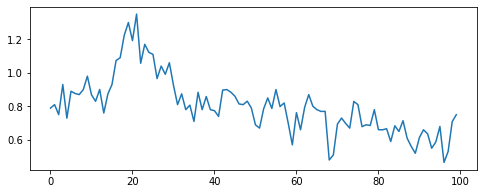

In [4]:
df.Mean[:100].plot()



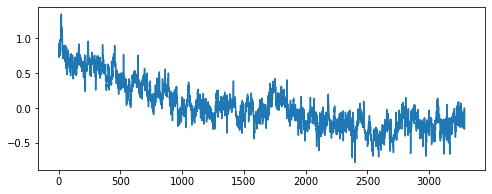

In [5]:
df.Mean.plot()




In [6]:
df = df.pivot(index='Date', columns='Source', values='Mean')


In [7]:
df.head()



Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


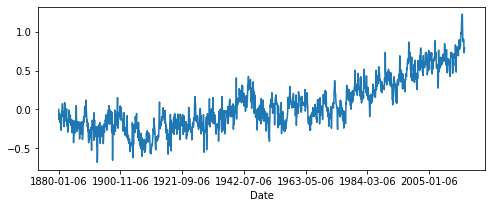

In [8]:
df.GCAG.plot()


In [9]:
type(df.index)


pandas.core.indexes.base.Index

In [10]:
df.index = pd.to_datetime(df.index)


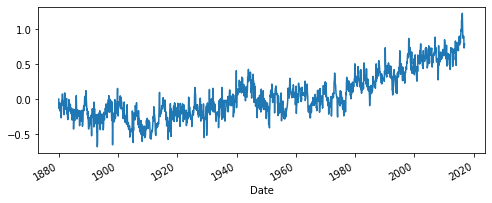

In [11]:
df.GCAG.plot()


In [12]:
df['1880']



Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14
1880-06-06,-0.1692,-0.29
1880-07-06,-0.1491,-0.24
1880-08-06,-0.0725,-0.08
1880-09-06,-0.0817,-0.17


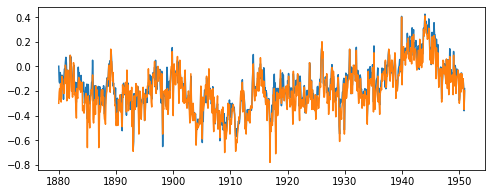

In [13]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])



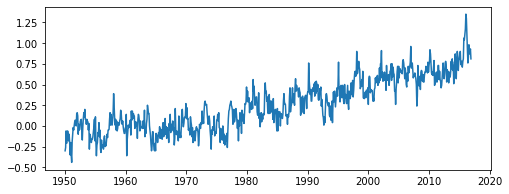

In [14]:
plt.plot(df['1950':][['GISTEMP']])


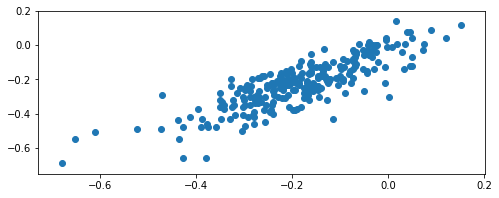

In [15]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])



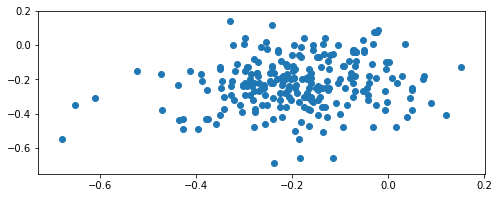

In [16]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])



In [17]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)


(0.15464057329612763, 0.01650223473095511)

In [18]:
df['1880':'1899'][['GCAG']].head()


Source,GCAG
Date,
1880-01-06,0.0009
1880-02-06,-0.1229
1880-03-06,-0.1357
1880-04-06,-0.0499
1880-05-06,-0.0738


In [19]:
df['1881':'1900'][['GISTEMP']].head()


Source,GISTEMP
Date,
1881-01-06,-0.10
1881-02-06,-0.14
1881-03-06,0.01
1881-04-06,-0.03
1881-05-06,-0.04


In [20]:
min(df.index)


Timestamp('1880-01-06 00:00:00')

In [21]:
max(df.index)



Timestamp('2016-12-06 00:00:00')

# Unobserved component model


In [22]:
train = df['1960':]




# model parameters


In [23]:
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}

# fitting a model



In [24]:
gcag_mod = sm.tsa.UnobservedComponents(train['GCAG'], **model)
gcag_res = gcag_mod.fit()


C:\Users\Jaiminkumar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


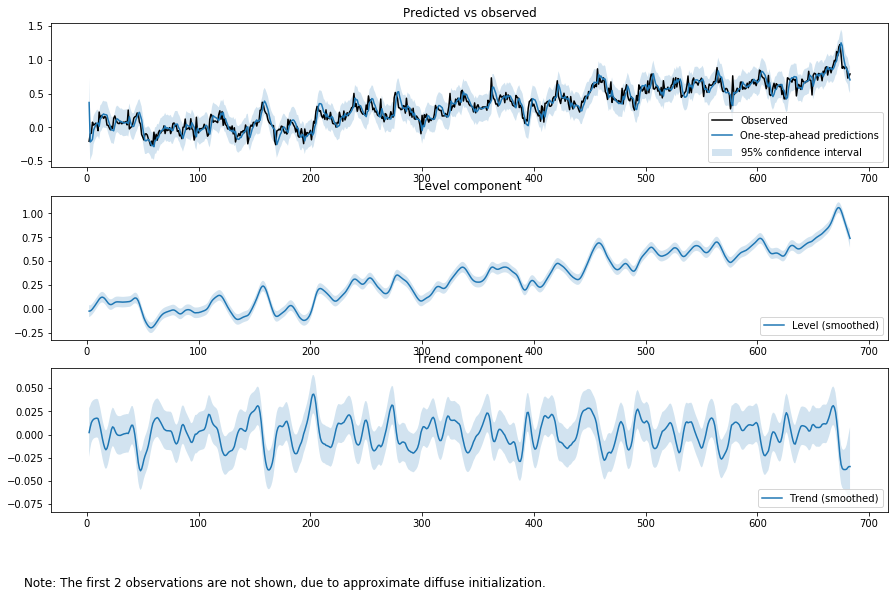

In [25]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));


# Plotting predictions


In [26]:
num_steps = 20
predict_res = gcag_res.get_prediction(dynamic=train['GCAG'].shape[0] - num_steps)

predict = predict_res.predicted_mean
ci = predict_res.conf_int()


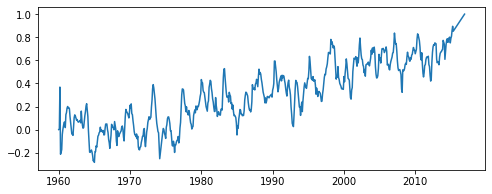

In [27]:
plt.plot(predict)


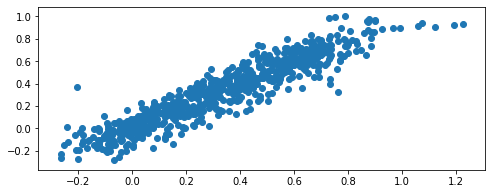

In [28]:
plt.scatter(train['GCAG'], predict)


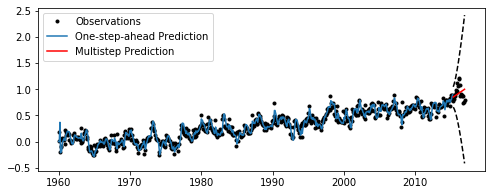

In [29]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train['GCAG'], 'k.', label='Observations');
ax.plot(train.index[:-num_steps], predict[:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image
legend = ax.legend(loc='upper left');



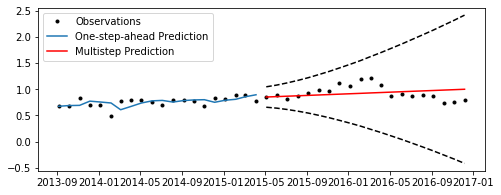

In [30]:
fig, ax = plt.subplots()
# Plot the results
ax.plot(train.index[-40:], train['GCAG'][-40:], 'k.', label='Observations');
ax.plot(train.index[-40:-num_steps], predict[-40:-num_steps], label='One-step-ahead Prediction');

ax.plot(train.index[-num_steps:], predict[-num_steps:], 'r', label='Multistep Prediction');
ax.plot(train.index[-num_steps:], ci.iloc[-num_steps:], 'k--');

# Cleanup the image

legend = ax.legend(loc='upper left');

# consider adding a seasonal term for 12 periods for the model fit above. Does this improve the fit of the model?



In [31]:
seasonal_model = {
    'level': 'local linear trend',
    'seasonal': 12
}
mod = sm.tsa.UnobservedComponents(train['GCAG'], **seasonal_model)
res = mod.fit(method='powell', disp=False)


C:\Users\Jaiminkumar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


C:\Users\Jaiminkumar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
C:\Users\Jaiminkumar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
C:\Users\Jaiminkumar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\structural.py:1723: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


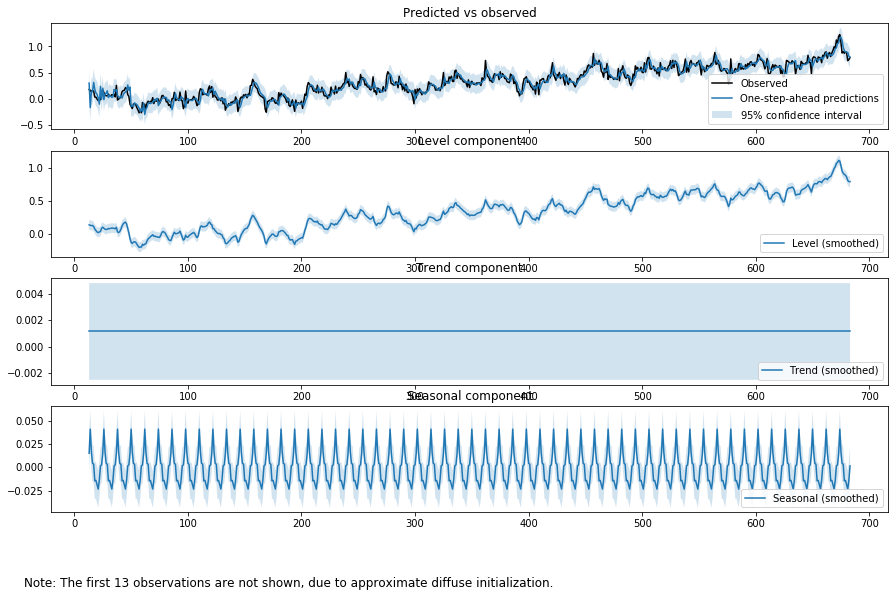

In [32]:
fig = res.plot_components(legend_loc='lower right', figsize=(15, 9));


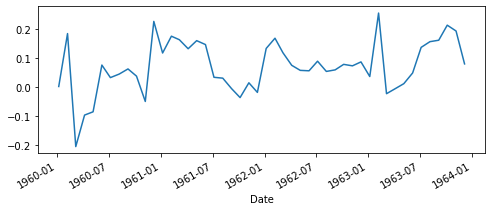

In [36]:
train[:48].GCAG.plot()
